In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from implementations import *
from proj1_helpers import *
from misc_helpers import *
from plot_functions import *
from ml_math import *
%load_ext autoreload
%autoreload 2

# Optimizing Learning by "brute force"

### Load Data

In [3]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y_data, x_data, ids = load_csv_data(DATA_TRAIN_PATH)

### Standardize

In [4]:
y = normalize(y_data)
x = normalize(x_data)

## Find the best number of gamma

### Define useful functions

In [36]:
# 'New' build_poly used in the labs correction, the old one should also work but you're never sure
def build_poly(x, degree):
    """
    ----------------------------------------------------------------------------
    Function that builds a matrix x to a polynomial matrix of of powers of x.
    ----------------------------------------------------------------------------
    Input:
    - x         parameter, (nsamples, nfeature) np.array
    - degree    number of dimension, if it is a float number, convert it into
                an integer
    Output:
    - poly      polynomial matrix, (nsamples, (nfeature*degree) + 1), np.array
    ----------------------------------------------------------------------------
    """
    poly = np.ones((len(x), 1))
    for deg in range(1, int(degree+1)):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

# Build_k_indices to do cross validation
def build_k_indices(y, k_fold, seed):
    """
    ----------------------------------------------------------------------------
    Function that builds "k_fold" sets of randomly distributed indices for an 
    array of size y.shape[0]
    ----------------------------------------------------------------------------
    Input:
    - y         array to be permuted in the future, (nsamples, 1) np.array
    - k_fold    number of sets of same size to be build, integer
    - seed      seed for the random number generator
    Output:
    - answ      k_folds set of randomly distributed indices, (k_fold, 
                nsamples/k_fold), np.array
    ----------------------------------------------------------------------------
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation_visualization(param, tested_parameter, rmse_tr, rmse_te, 
                                   graph_type = "log", label="", color1 = "r", color2 = "b"):
    """
    ----------------------------------------------------------------------------
    Function that plots the error in training and in test as a function of a
    given parameter, then saves it with the name "cross_validation".
    ----------------------------------------------------------------------------
    Input:
    - param             values of the parameter, array
    - tested_parameter  name of the parameter, string
    - rmse_tr           training error, array
    - rmse_te           test error, array
    - graph_type        choose between a loglog graph - "log" - and a semilogy
                        - otherwise - graph, string, (Default = "log")
    - label             gives additional information on the label, string
                        (Default = "")
    - color1            color of the train data (Default = "r")
    - color2            color of the test data (Default = "b")
    Output:
    ----------------------------------------------------------------------------
    """
    if (graph_type == "log"):
        plt.loglog(param, rmse_tr, marker=".", color=color1, label='train error' + " " + label)
        plt.loglog(param, rmse_te, marker=".", color=color2, label='test error' + " " + label)
    else:
        plt.semilogy(param, rmse_tr, marker=".", color=color1, label='train error' + " " + label)
        plt.semilogy(param, rmse_te, marker=".", color=color2, label='test error' + " " + label)
    plt.xlabel(tested_parameter)
    plt.ylabel("error")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation_" + tested_parameter)

### Implement cross-validation

In [6]:
def cross_validation(y, x, k_indices, k, degree, gamma, lambda_, max_iters, method, w0):
    """
    ----------------------------------------------------------------------------
    Function that implements the cross-validation given multiple parameters.
    Returns the calculated, loss in both the training and test sets, and the
    weights
    ----------------------------------------------------------------------------
    Input:
    - y         "measured" objective function, (nsamples,1) np.array
    - x         features, (nsamples,nfeatures) np.array
    - k_indices k_fold sets of randomly distributed indices, (k_fold, 
                nsamples/k_fold), np.array
    - k         number of the set to use as test set
    - degree    number of dimension
    - gamma     step size, scalar in ]0,1[
    - lambda_   regularization parameter, scalar>0
    - max_iters # of iterations after which the procedure will stop, int>0
    - method    method to use in this cross-validation iteration, integer 
                between 0 to 6 (0 = least_square_GD, 1 = least_square_SGD,
                2 = least_squares, 3 = ridge_regression, 4 = 
                logistic_regression, 5 = reg_logistic_regression, 6 = 
                new_ridge_regression_GD)
    - w0
    Output:
    - w             obtained weights, (nfeatures,1) np.array
    - loss_tr       loss on the training set, scalar
    - loss_te       loss on the test set, scalar
    ----------------------------------------------------------------------------
    """
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    loss_function = "MSE"
    
    if method == 0:
        tx_tr = build_poly(x_tr, degree)
        tx_te = build_poly(x_te, degree)
        initial_w = np.ones(len(tx_tr[1,:])) * w0
        w, loss_tr = least_squares_GD(y_tr, tx_tr, initial_w, max_iters, gamma, verbose=False)
    if method == 1:
        tx_tr = build_poly(x_tr, degree)
        tx_te = build_poly(x_te, degree)
        initial_w = np.ones(len(tx_tr[1,:])) * w0
        w, loss_tr = least_squares_SGD(y_tr, tx_tr, initial_w, 1, max_iters, gamma, verbose=False)
    if method == 2:
        tx_tr = build_poly(x_tr, degree)
        tx_te = build_poly(x_te, degree)
        w, loss_tr = least_squares(y_tr, tx_tr)
    if method == 3:
        tx_tr = build_poly(x_tr, degree)
        tx_te = build_poly(x_te, degree)
        w, loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
    if method == 4:
        loss_function = "MSE"
        tx_tr = build_poly(x_tr, degree)
        tx_te = build_poly(x_te, degree)
        initial_w = np.ones(len(tx_tr[1,:])) * w0
        w, loss_tr = logistic_regression(y_tr, tx_tr, initial_w, max_iters, gamma, verbose = False, use_SGD = True, batch_size = 1, loss_function = "LL2")
    if method == 5:
        loss_function = "MSE"
        tx_tr = build_poly(x_tr, degree)
        tx_te = build_poly(x_te, degree)
        initial_w = np.ones(len(tx_tr[1,:])) * w0
        w, loss_tr = reg_logistic_regression(y_tr, tx_tr, lambda_, initial_w, max_iters, gamma, verbose = False, use_SGD = True, batch_size = 1, loss_function = "LL2")
    if method == 6:
        tx_tr = build_poly(x_tr, degree)
        tx_te = build_poly(x_te, degree)
        initial_w = np.ones(len(tx_tr[1,:])) * w0
        w, loss_tr = new_ridge_regression_GD(y_tr, tx_tr, initial_w, lambda_, gamma, max_iters, verbose=False)
    
    # calculate the loss for test data
    loss_te = compute_loss(y_te, tx_te, w, loss_function)
    return loss_tr, loss_te, w

### Define tests on all parameters

In [7]:
def test_all():
    """
    ----------------------------------------------------------------------------
    Function that test all the variable parameters in a huge for loop.
    Warning! Takes a really long time to compute.
    ----------------------------------------------------------------------------
    """
    
    
    # define the system constant parameters
    seed = 1
    k_fold = 4
    k_indices = build_k_indices(y, k_fold, seed)
    max_iters = 20
    rmse_tr = []
    rmse_te = []
    best_rmse_te = np.ones(7)*999999
    best_rmse_tr = np.ones(7)
    best_method = np.ones(7)
    best_degree = np.ones(7)
    best_gamma = np.ones(7)
    best_lambda = np.ones(7)
    best_w0 = np.ones(7)
    i = 0
    
    # define the system variable parameters
    methods = np.linspace(0, 6, 7)
    degrees = np.linspace(3, 7, 5)
    gammas = np.logspace(-3, 0, 4)
    lambdas = np.logspace(-3, 1, 5)
    w0s = np.linspace(-5, 5, 3)
    
    for method in methods:
        for degree in degrees:
            for gamma in gammas:
                for lambda_ in lambdas:
                    for w0 in w0s:
                        rmse_tr_tmp = []
                        rmse_te_tmp = []
                        for k in range(k_fold):
                            loss_tr, loss_te, _ = cross_validation(y, x, k_indices, k, degree, gamma, lambda_, max_iters, method, w0)
                            rmse_tr_tmp.append(loss_tr)
                            rmse_te_tmp.append(loss_te)
                        rmse_tr = np.mean(rmse_tr_tmp)
                        rmse_te = np.mean(rmse_te_tmp)
                        if rmse_te < best_rmse_te[int(method)]:
                            best_rmse_te[int(method)] = rmse_te
                            best_rmse_tr[int(method)] = rmse_tr
                            best_method[int(method)] = method
                            best_degree[int(method)] = degree
                            best_gamma[int(method)] = gamma
                            best_lambda[int(method)] = lambda_
                            best_w0[int(method)] = w0
                        i = i + 1
                        print(str(i / (7 * 5 * 4 * 5 * 3) * 100) + "% done")
    # print("Best rmse_te = %s ; Best rmse_tr = %s ; Best method = %s ; Best degree = %s ; Best gamma = %s ; Best lambda = %s ; Best w0 = %s" % (best_rmse_te, best_rmse_tr, best_method, best_degree, best_gamma, best_lambda, best_w0))
    print(best_rmse_te)
    print(best_rmse_tr)
    print(best_method)
    print(best_degree)
    print(best_gamma)
    print(best_lambda)
    print(best_w0)
    return best_rmse_te, best_rmse_tr, best_method, best_degree, best_gamma, best_lambda, best_w0

In [8]:
test_all()

0.047619047619047616% done
0.09523809523809523% done
0.14285714285714285% done
0.19047619047619047% done
0.2380952380952381% done
0.2857142857142857% done
0.33333333333333337% done
0.38095238095238093% done
0.4285714285714286% done
0.4761904761904762% done
0.5238095238095238% done
0.5714285714285714% done
0.6190476190476191% done
0.6666666666666667% done
0.7142857142857143% done
0.7619047619047619% done
0.8095238095238094% done
0.8571428571428572% done
0.9047619047619048% done
0.9523809523809524% done
1.0% done
1.0476190476190477% done
1.0952380952380953% done
1.1428571428571428% done
1.1904761904761905% done
1.2380952380952381% done
1.2857142857142856% done
1.3333333333333335% done
1.380952380952381% done
1.4285714285714286% done
1.4761904761904763% done
1.5238095238095237% done
1.5714285714285716% done
1.6190476190476188% done
1.6666666666666667% done
1.7142857142857144% done
1.7619047619047619% done
1.8095238095238095% done
1.8571428571428572% done
1.9047619047619049% done
1.9523809

16.333333333333332% done
16.380952380952383% done
16.428571428571427% done
16.476190476190474% done
16.523809523809526% done
16.57142857142857% done
16.61904761904762% done
16.666666666666664% done
16.714285714285715% done
16.761904761904763% done
16.80952380952381% done
16.857142857142858% done
16.904761904761905% done
16.952380952380953% done
17.0% done
17.047619047619047% done
17.095238095238095% done
17.142857142857142% done
17.19047619047619% done
17.238095238095237% done
17.285714285714285% done
17.333333333333336% done
17.38095238095238% done
17.42857142857143% done
17.476190476190474% done
17.523809523809526% done
17.57142857142857% done
17.61904761904762% done
17.666666666666668% done
17.71428571428571% done
17.761904761904763% done
17.80952380952381% done
17.857142857142858% done
17.904761904761905% done
17.952380952380953% done
18.0% done
18.047619047619047% done
18.095238095238095% done
18.142857142857142% done
18.19047619047619% done
18.23809523809524% done
18.285714285714

32.52380952380952% done
32.57142857142858% done
32.61904761904762% done
32.666666666666664% done
32.714285714285715% done
32.761904761904766% done
32.80952380952381% done
32.857142857142854% done
32.904761904761905% done
32.95238095238095% done
33.0% done
33.04761904761905% done
33.095238095238095% done
33.14285714285714% done
33.19047619047619% done
33.23809523809524% done
33.285714285714285% done
33.33333333333333% done
33.38095238095239% done
33.42857142857143% done
33.476190476190474% done
33.523809523809526% done
33.57142857142857% done
33.61904761904762% done
33.666666666666664% done
33.714285714285715% done
33.76190476190476% done
33.80952380952381% done
33.85714285714286% done
33.904761904761905% done
33.95238095238095% done
34.0% done
34.04761904761905% done
34.095238095238095% done
34.14285714285714% done
34.19047619047619% done
34.23809523809524% done
34.285714285714285% done
34.333333333333336% done
34.38095238095238% done
34.42857142857143% done
34.476190476190474% done
34

48.904761904761905% done
48.952380952380956% done
49.0% done
49.047619047619044% done
49.095238095238095% done
49.142857142857146% done
49.19047619047619% done
49.238095238095234% done
49.28571428571429% done
49.333333333333336% done
49.38095238095238% done
49.42857142857143% done
49.476190476190474% done
49.523809523809526% done
49.57142857142857% done
49.61904761904762% done
49.666666666666664% done
49.714285714285715% done
49.76190476190476% done
49.80952380952381% done
49.857142857142854% done
49.904761904761905% done
49.952380952380956% done
50.0% done
50.04761904761905% done
50.095238095238095% done
50.142857142857146% done
50.19047619047618% done
50.23809523809524% done
50.28571428571429% done
50.33333333333333% done
50.38095238095238% done
50.42857142857143% done
50.476190476190474% done
50.523809523809526% done
50.57142857142857% done
50.61904761904762% done
50.66666666666667% done
50.71428571428571% done
50.761904761904766% done
50.8095238095238% done
50.857142857142854% done

65.33333333333333% done
65.38095238095238% done
65.42857142857143% done
65.47619047619048% done
65.52380952380953% done
65.57142857142857% done
65.61904761904762% done
65.66666666666666% done
65.71428571428571% done
65.76190476190476% done
65.80952380952381% done
65.85714285714286% done
65.9047619047619% done
65.95238095238095% done
66.0% done
66.04761904761904% done
66.0952380952381% done
66.14285714285715% done
66.19047619047619% done
66.23809523809524% done
66.28571428571428% done
66.33333333333333% done
66.38095238095238% done
66.42857142857143% done
66.47619047619048% done
66.52380952380952% done
66.57142857142857% done
66.61904761904762% done
66.66666666666666% done
66.71428571428571% done
66.76190476190477% done
66.80952380952381% done
66.85714285714286% done
66.9047619047619% done
66.95238095238095% done
67.0% done
67.04761904761905% done
67.0952380952381% done
67.14285714285714% done
67.19047619047619% done
67.23809523809524% done
67.28571428571428% done
67.33333333333333% don

82.0952380952381% done
82.14285714285714% done
82.19047619047619% done
82.23809523809524% done
82.28571428571428% done
82.33333333333334% done
82.38095238095238% done
82.42857142857143% done
82.47619047619048% done
82.52380952380952% done
82.57142857142857% done
82.61904761904762% done
82.66666666666667% done
82.71428571428572% done
82.76190476190476% done
82.80952380952381% done
82.85714285714286% done
82.9047619047619% done
82.95238095238095% done
83.0% done
83.04761904761905% done
83.0952380952381% done
83.14285714285714% done
83.19047619047619% done
83.23809523809523% done
83.28571428571429% done
83.33333333333334% done
83.38095238095238% done
83.42857142857143% done
83.47619047619048% done
83.52380952380952% done
83.57142857142857% done
83.61904761904762% done
83.66666666666667% done
83.71428571428572% done
83.76190476190476% done
83.80952380952381% done
83.85714285714285% done
83.9047619047619% done
83.95238095238096% done
84.0% done
84.04761904761905% done
84.0952380952381% done

98.80952380952381% done
98.85714285714286% done
98.90476190476191% done
98.95238095238095% done
99.0% done
99.04761904761905% done
99.09523809523809% done
99.14285714285714% done
99.19047619047619% done
99.23809523809524% done
99.28571428571429% done
99.33333333333333% done
99.38095238095238% done
99.42857142857143% done
99.47619047619047% done
99.52380952380952% done
99.57142857142857% done
99.61904761904762% done
99.66666666666667% done
99.71428571428571% done
99.76190476190476% done
99.80952380952381% done
99.85714285714286% done
99.90476190476191% done
99.95238095238095% done
100.0% done
[1.80190109e-06 1.81451176e-06 6.17078089e-05 1.79951274e-06
 4.55177000e-05 3.12224354e-05 1.80190370e-06]
[1.80187025e-06 1.84171018e-06 1.24273614e-06 1.79947645e-06
 4.99685336e-01 5.00319290e-01 1.80226896e-06]
[0. 1. 2. 3. 4. 5. 6.]
[4. 3. 3. 3. 3. 4. 3.]
[1.    0.1   0.001 0.001 0.001 0.001 1.   ]
[1.e-03 1.e+00 1.e-03 1.e-03 1.e+00 1.e+01 1.e-03]
[ 0.  0. -5. -5.  0.  0.  0.]


(array([1.80190109e-06, 1.81451176e-06, 6.17078089e-05, 1.79951274e-06,
        4.55177000e-05, 3.12224354e-05, 1.80190370e-06]),
 array([1.80187025e-06, 1.84171018e-06, 1.24273614e-06, 1.79947645e-06,
        4.99685336e-01, 5.00319290e-01, 1.80226896e-06]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 array([4., 3., 3., 3., 3., 4., 3.]),
 array([1.   , 0.1  , 0.001, 0.001, 0.001, 0.001, 1.   ]),
 array([1.e-03, 1.e+00, 1.e-03, 1.e-03, 1.e+00, 1.e+01, 1.e-03]),
 array([ 0.,  0., -5., -5.,  0.,  0.,  0.]))

In [78]:
def test_ridge_regression():
    """
    ----------------------------------------------------------------------------
    Function that try to find the best parameters for ridge regression.
    ----------------------------------------------------------------------------
    """
    
    
    # define the system constant parameters
    seed = 1
    k_fold = 4
    k_indices = build_k_indices(y, k_fold, seed)
    max_iters = 20
    rmse_tr = []
    rmse_te = []
    best_rmse_te = 999999
    best_rmse_tr = 0
    best_degree = 0
    best_lambda = 0
    i = 0
    j = 0
    
    gamma = 0
    method = 3
    w0 = 0
    
    # define the system variable parameters
    degrees = np.linspace(3, 4, 2)
    lambdas = np.logspace(-20, -1, 20)
    
    for degree in degrees:
        for lambda_ in lambdas:
            rmse_tr_tmp = []
            rmse_te_tmp = []
            for k in range(k_fold):
                loss_tr, loss_te, _ = cross_validation(y, x, k_indices, k, degree, gamma, lambda_, max_iters, method, w0)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
            rmse_tr.append(np.mean(rmse_tr_tmp))
            rmse_te.append(np.mean(rmse_te_tmp))
            if rmse_te[i] < best_rmse_te:
                best_rmse_te = rmse_te[i]
                best_rmse_tr = rmse_tr[i]
                best_degree = degree
                best_lambda = lambda_
            i = i + 1
            print(str(i / (2 * 20) * 100) + "% done")
        cross_validation_visualization(lambdas, "lambda", rmse_tr[int((j)*20):int((j+1)*20)], rmse_te[int((j)*20):int((j+1)*20)], "log","degree = " + str(degree),([0, 0, j]),([1, 0, j]))     
        j = j + 1 
    print(best_rmse_te)
    print(best_rmse_tr)
    print(best_degree)
    print(best_lambda)
    return best_rmse_te, best_rmse_tr, best_degree, best_lambda

2.5% done
5.0% done
7.5% done
10.0% done
12.5% done
15.0% done
17.5% done
20.0% done
22.5% done
25.0% done
27.500000000000004% done
30.0% done
32.5% done
35.0% done
37.5% done
40.0% done
42.5% done
45.0% done
47.5% done
50.0% done
52.5% done
55.00000000000001% done
57.49999999999999% done
60.0% done
62.5% done
65.0% done
67.5% done
70.0% done
72.5% done
75.0% done
77.5% done
80.0% done
82.5% done
85.0% done
87.5% done
90.0% done
92.5% done
95.0% done
97.5% done
100.0% done
1.305807292276056e-06
1.292993618610474e-06
3.0
1e-14


(1.305807292276056e-06, 1.292993618610474e-06, 3.0, 1e-14)

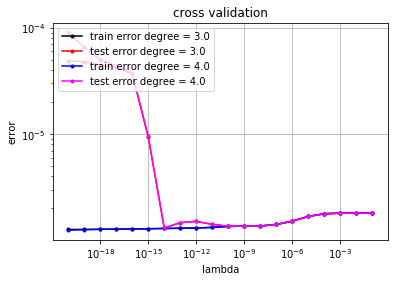

In [77]:
test_ridge_regression()